## Thanks to @junhyeok99 https://www.kaggle.com/junhyeok99/automl-pycaret

In [1]:
!pip install -q pycaret

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.4.1 which is incompatible.


# Libraries
---

In [2]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import random
import os
import gc

from pycaret.regression import setup, compare_models, tune_model, blend_models, finalize_model, predict_model, plot_model

import statsmodels.api as sm

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.simplefilter('ignore')

In [3]:
CFG = {
    'carbon_monoxide': {
        'target': 'target_carbon_monoxide',
        'seed': 2021,
        'n_select': 2,
        'fold': 3,
        'fold_strategy': 'timeseries',
        'tuning': False,
        'normalize': True,
        'optimize': 'RMSE',
    },
    'benzene': {
        'target': 'target_benzene',
        'seed': 2021,
        'n_select': 2,
        'fold': 3,
        'fold_strategy': 'timeseries',
        'tuning': False,
        'normalize': True,
        'optimize': 'RMSE',        
    },
    'nitrogen_oxides': {
        'target': 'target_nitrogen_oxides',
        'seed': 2021,
        'n_select': 2,
        'fold': 2,
        'fold_strategy': 'timeseries',
        'tuning': False,
        'normalize': True,
        'optimize': 'RMSE',        
    },
}

In [4]:
def seed_everything(seed=2021):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything()

# Datasets
---

* Thanks to @alexryzhkov, [TPS LightAutoML baseline (with pseudolabels)](https://www.kaggle.com/alexryzhkov/tps-lightautoml-baseline-with-pseudolabels?scriptVersionId=67757271)

In [5]:
train = pd.read_csv("../input/tabular-playground-series-jul-2021/train.csv", index_col="date_time", parse_dates=True)
test = pd.read_csv("../input/tabular-playground-series-jul-2021/test.csv", index_col="date_time", parse_dates=True)
submission = pd.read_csv("../input/tabular-playground-series-jul-2021/sample_submission.csv", index_col="date_time", parse_dates=True)

pseudo_label = pd.read_csv("../input/tps0718967/lightautoml_with_pseudolabelling_kernel_version_6.csv", index_col="date_time", parse_dates=True)
test = pd.concat([test, pseudo_label], axis=1)

target = [col for col in train.columns if 'target_' in col]
train[target] = np.log1p(train[target])
test[target] = np.log1p(test[target])

# Feature engineering
---

In [6]:
def make_CO_features(df):
    """
    Adds new features to a given dataset
    """
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['week'] = df.index.week
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['time'] = df.index.date - df.index.date.min()
    df['hour'] = df.index.hour
    df['time'] = df['time'].apply(lambda x : x.days)

    df['working_hours'] =  df['hour'].isin(np.arange(8, 21, 1)).astype('int')
    df['maximum_hours'] =  df['hour'].isin([8, 9, 17, 18, 19, 20]).astype('int')
    df['is_weekend'] = (df.index.dayofweek >= 5).astype('int')

    df['SMC'] = (df['absolute_humidity'] * 100) / df['relative_humidity']
    
    df['sensor_6'] = (df['sensor_2'] - df['sensor_5']) / df['sensor_5']
    df['sensor_7'] = (df['sensor_3'] - df['sensor_4']) / df['sensor_4']

    for periods in [3, 6]:
        df[f'dt-{periods}'] = df['deg_C'] - df['deg_C'].shift(periods=periods, fill_value=0)

    for periods in [3, 6]:
        df[f'abshum-{periods}'] = df['absolute_humidity'] - df['absolute_humidity'].shift(periods=periods, fill_value=0)
        df[f'relhum-{periods}'] = df['relative_humidity'] - df['relative_humidity'].shift(periods=periods, fill_value=0)
        
    for periods in [1]:
        df[f's1-{periods}'] = df['sensor_1'] - df['sensor_1'].shift(periods=periods, fill_value=0)
        df[f's2-{periods}'] = df['sensor_2'] - df['sensor_2'].shift(periods=periods, fill_value=0)
        df[f's3-{periods}'] = df['sensor_3'] - df['sensor_3'].shift(periods=periods, fill_value=0)
        df[f's4-{periods}'] = df['sensor_4'] - df['sensor_4'].shift(periods=periods, fill_value=0)
        df[f's5-{periods}'] = df['sensor_5'] - df['sensor_5'].shift(periods=periods, fill_value=0)
        df[f's6-{periods}'] = df['sensor_6'] - df['sensor_6'].shift(periods=periods, fill_value=0)
        df[f's7-{periods}'] = df['sensor_7'] - df['sensor_7'].shift(periods=periods, fill_value=0)
            
    return df

In [7]:
def make_C6H6_features(df):
    """
    Adds new features to a given dataset
    """
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['week'] = df.index.week
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['time'] = df.index.date - df.index.date.min()
    df['hour'] = df.index.hour
    df['time'] = df['time'].apply(lambda x : x.days)

    df['working_hours'] =  df['hour'].isin(np.arange(8, 21, 1)).astype('int')
    df['maximum_hours'] =  df['hour'].isin([8, 9, 17, 18, 19, 20]).astype('int')
    df['is_weekend'] = (df.index.dayofweek >= 5).astype('int')

    df['SMC'] = (df['absolute_humidity'] * 100) / df['relative_humidity']
    
    df['sensor_6'] = (df['sensor_2'] - df['sensor_5']) / df['sensor_5']
    df['sensor_7'] = (df['sensor_3'] - df['sensor_4']) / df['sensor_4']

    for periods in [3, 6]:
        df[f'dt-{periods}'] = df['deg_C'] - df['deg_C'].shift(periods=periods, fill_value=0)

    for periods in [3, 6]:
        df[f'abshum-{periods}'] = df['absolute_humidity'] - df['absolute_humidity'].shift(periods=periods, fill_value=0)
        df[f'relhum-{periods}'] = df['relative_humidity'] - df['relative_humidity'].shift(periods=periods, fill_value=0)
        
    for periods in [1]:
        df[f's1-{periods}'] = df['sensor_1'] - df['sensor_1'].shift(periods=periods, fill_value=0)
        df[f's2-{periods}'] = df['sensor_2'] - df['sensor_2'].shift(periods=periods, fill_value=0)
        df[f's3-{periods}'] = df['sensor_3'] - df['sensor_3'].shift(periods=periods, fill_value=0)
        df[f's4-{periods}'] = df['sensor_4'] - df['sensor_4'].shift(periods=periods, fill_value=0)
        df[f's5-{periods}'] = df['sensor_5'] - df['sensor_5'].shift(periods=periods, fill_value=0)
        df[f's6-{periods}'] = df['sensor_6'] - df['sensor_6'].shift(periods=periods, fill_value=0)
        df[f's7-{periods}'] = df['sensor_7'] - df['sensor_7'].shift(periods=periods, fill_value=0)
            
    return df

In [8]:
def make_NOx_features(df):
    """
    Adds new features to a given dataset
    """
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['week'] = df.index.week
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['time'] = df.index.date - df.index.date.min()
    df['hour'] = df.index.hour
    df['time'] = df['time'].apply(lambda x : x.days)

    df['working_hours'] =  df['hour'].isin(np.arange(8, 21, 1)).astype('int')
    df['maximum_hours'] =  df['hour'].isin([8, 9, 17, 18, 19, 20]).astype('int')
    df['is_weekend'] = (df.index.dayofweek >= 5).astype('int')

    df['SMC'] = (df['absolute_humidity'] * 100) / df['relative_humidity']
    
    df['sensor_6'] = (df['sensor_2'] - df['sensor_5']) / df['sensor_5']
    df['sensor_7'] = (df['sensor_3'] - df['sensor_4']) / df['sensor_4']

    for periods in [3, 6]:
        df[f'dt-{periods}'] = df['deg_C'] - df['deg_C'].shift(periods=periods, fill_value=0)

    for periods in [3, 6]:
        df[f'abshum-{periods}'] = df['absolute_humidity'] - df['absolute_humidity'].shift(periods=periods, fill_value=0)
        df[f'relhum-{periods}'] = df['relative_humidity'] - df['relative_humidity'].shift(periods=periods, fill_value=0)
        
    for periods in [1]:
        df[f's1-{periods}'] = df['sensor_1'] - df['sensor_1'].shift(periods=periods, fill_value=0)
        df[f's2-{periods}'] = df['sensor_2'] - df['sensor_2'].shift(periods=periods, fill_value=0)
        df[f's3-{periods}'] = df['sensor_3'] - df['sensor_3'].shift(periods=periods, fill_value=0)
        df[f's4-{periods}'] = df['sensor_4'] - df['sensor_4'].shift(periods=periods, fill_value=0)
        df[f's5-{periods}'] = df['sensor_5'] - df['sensor_5'].shift(periods=periods, fill_value=0)
        df[f's6-{periods}'] = df['sensor_6'] - df['sensor_6'].shift(periods=periods, fill_value=0)
        df[f's7-{periods}'] = df['sensor_7'] - df['sensor_7'].shift(periods=periods, fill_value=0)
            
    return df

# PyCaret
---

In [9]:
def pycaret_model(train, test, config):
    print('Setup Your Data....')
    setup(
        data=train,
        target=config['target'],
        numeric_imputation='mean',
        session_id=config['seed'],
        normalize = config['normalize'],
        silent= True,
        fold_strategy=config['fold_strategy'],
    )

    print(f"Comparing Models....")
    best = compare_models(sort=config['optimize'], n_select=config['n_select'], fold=config['fold'], exclude=['xgboost'])

    if config['tuning']:
        print(f"Tuning Models....")
        best_tuned = [tune_model(model) for model in best]

        print(f"Blending Models....")
        blended = blend_models(estimator_list=best+best_tuned, fold=config['fold'], optimize=config['optimize'])
    else:
        print(f"Blending Models....")
        blended = blend_models(estimator_list=best, fold=config['fold'], optimize=config['optimize'])
        
    pred_holdout = predict_model(blended)

    print(f"Finallizing Models....")
    final_model = finalize_model(blended)

    print('Done...!!!')
    pred = predict_model(final_model, test)
    re = pred['Label']

    return re, final_model

## for Carbon Monoxide

In [10]:
# 'target_carbon_monoxide'
X = train.copy()
all_df = make_CO_features(pd.concat([X, test]))

X_train = all_df.copy()
X_test = all_df[len(X):].copy()

pred_CO, model_CO = pycaret_model(X_train, X_test, CFG['carbon_monoxide'])
submission[CFG['carbon_monoxide']['target']] = np.expm1(pred_CO)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0544,0.0062,0.0789,0.9643,0.0430,0.0757
1,0.0527,0.0054,0.0736,0.9705,0.0374,0.0658
2,0.0481,0.0044,0.0661,0.9746,0.0339,0.0570
Mean,0.0518,0.0053,0.0729,0.9698,0.0381,0.0661
SD,0.0026,0.0008,0.0052,0.0042,0.0037,0.0076


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0495,0.0050,0.0710,0.9713,0.0370,0.0627


Finallizing Models....
Done...!!!


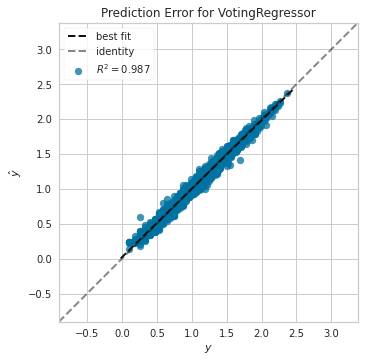

In [11]:
plot_model(model_CO, plot='error')

## for Benzene

In [12]:
# 'target_benzene'
X = train.copy()
all_df = make_C6H6_features(pd.concat([X, test]))
features = [col for col in all_df.columns if 'target_' not in col]

X_train = all_df.copy()
X_test = all_df[len(X):].copy()

pred_C6H6, model_C6H6 = pycaret_model(X_train, X_test, CFG['benzene'])
submission[CFG['benzene']['target']] = np.expm1(pred_C6H6)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0547,0.0054,0.0733,0.9911,0.0263,0.0364
1,0.0517,0.0048,0.0693,0.9928,0.0238,0.0340
2,0.0493,0.0046,0.0680,0.9923,0.0234,0.0316
Mean,0.0519,0.0049,0.0702,0.9921,0.0245,0.0340
SD,0.0022,0.0003,0.0023,0.0007,0.0013,0.0020


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0490,0.0043,0.0655,0.9930,0.0228,0.0309


Finallizing Models....
Done...!!!


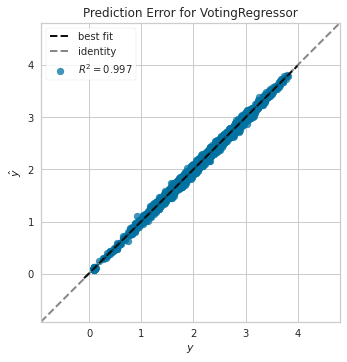

In [13]:
plot_model(model_C6H6, plot='error')

## for Nitrogen Oxides

In [14]:
# 'target_nitrogen_oxides'
X = train[train.index.month>8].copy()
all_df = make_NOx_features(pd.concat([X, test]))
features = [col for col in all_df.columns if 'target_' not in col]

X_train = all_df.copy()
X_test = all_df[len(X):].copy()

pred_NOx, model_NOx = pycaret_model(X_train, X_test, CFG['nitrogen_oxides'])
submission[CFG['nitrogen_oxides']['target']] = np.expm1(pred_NOx)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1018,0.0219,0.1479,0.9610,0.0243,0.0193
1,0.0871,0.0174,0.1317,0.9670,0.0211,0.0163
Mean,0.0945,0.0196,0.1398,0.9640,0.0227,0.0178
SD,0.0073,0.0023,0.0081,0.0030,0.0016,0.0015


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0821,0.0163,0.1277,0.9686,0.0213,0.0156


Finallizing Models....
Done...!!!


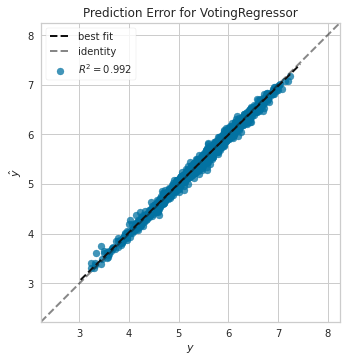

In [15]:
plot_model(model_NOx, plot='error')

# Submission
---

In [16]:
submission.to_csv('submission.csv')

In [17]:
pd.read_csv("submission.csv")

,date_time,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2011-01-01 00:00:00,1.650458,4.985949,227.532423
1,2011-01-01 01:00:00,1.979105,7.360327,291.118540
2,2011-01-01 02:00:00,1.804107,7.065741,277.067988
3,2011-01-01 03:00:00,1.900391,7.848594,298.968277
4,2011-01-01 04:00:00,1.405776,6.210499,224.051321
...,...,...,...,...
2242,2011-04-04 10:00:00,2.771181,12.659146,329.377057
2243,2011-04-04 11:00:00,2.283471,10.458343,284.015875
2244,2011-04-04 12:00:00,2.489370,12.474223,294.222072
2245,2011-04-04 13:00:00,2.069291,10.426391,202.997549
